Let's start by creating a simple linear model for digit recognition.

## Accessing the data

We'll download the famous [MNIST dataset](http://yann.lecun.com/exdb/mnist/) of handwritten digits.

In [1]:
url = 'https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz'
tgz = 'mnist_png.tgz'

We can use `urlsave` from [fastcore](https://fastcore.fast.ai/) to download the dataset. However, we don't want to re-download it if we've downloaded it before. We can use Python's `Path` class to make it more convenient to work with the filesystem.

In [2]:
from pathlib import Path
from fastcore.all import urlsave

cfghome = Path.home()/'.fastai'
archive = cfghome/'archive'
if not (archive/tgz).exists():
    archive.mkdir(exist_ok=True, parents=True)
    urlsave(url, archive)

We can follow similar logic for decompressing the archive:

In [4]:
from fastcore.all import untar_dir
data = cfghome/'data'
dest = data/'mnist_png'
if not dest.exists():
    data.mkdir(exist_ok=True, parents=True)
    untar_dir(archive/tgz, dest)

In [ ]:
#TODO: use FastDownload when available

The dataset has separate folders for the training set and the test set (which we will use for validation). We use the `ls` method to quickly see the contents of a folder in a cross-platform way. Setting `Path.BASE_PATH=dest` causes the `dest` component of paths to not be displayed.

In [6]:
Path.BASE_PATH=dest
dest.ls()

(#2) [Path('testing'),Path('training')]

The training set is split into folders according to the labels:

In [7]:
trainpath = dest/'training'
testpath = dest/'testing'
trainpath.ls()

(#10) [Path('training/0'),Path('training/1'),Path('training/2'),Path('training/3'),Path('training/4'),Path('training/5'),Path('training/6'),Path('training/7'),Path('training/8'),Path('training/9')]

With `glob` we can get a list of all of the files in the training and test sets, using a [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions):

In [8]:
from glob import glob
def getfiles(p): return [Path(o) for o in sorted(glob(f'{p}/**/*.png', recursive=True))]

trainfiles = getfiles(trainpath)
testfiles = getfiles(testpath)
fname = trainfiles[0]
fname

Path('training/0/1.png')

We can see from the path that this is the number "8", and is in the training set. We can open the image file using [torchvision](https://pytorch.org/vision/stable/index.html):

In [12]:
from torchvision.io import read_image
img = read_image(str(fname))

This returns a `Tensor` (a multidimensional array). We can see its size:

In [13]:
img.shape

torch.Size([1, 28, 28])

This shows that it is a single image of size 28x28. We can view it using matplotlib (note that matplotlib expects a 28x28 tensor, so we index into the first dimension to get that):

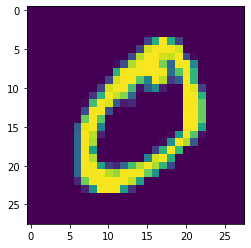

In [14]:
import matplotlib.pyplot as plt

plt.imshow(img[0]);

## Creating variables

For a linear model, we'll need independent variables (the pixel values) and a dependent variable (the labels).

We need to flatten the rank-3, 1x28x28 shaped tensor into a vector (i.e a length 28 rank-1 tensor). Reminder: *rank* refers to the number of dimensions in a tensor, and is equal to the length of a tensor's shape vector.

We can use `view(-1)` for this purpose:

In [15]:
def x_func(p): return read_image(str(p)).view(-1)

x_func(fname).shape

torch.Size([784])

Our labels need to be numbers or tensors of numbers. For MNIST, we can use `int` to create integers from the parent folder names:

In [16]:
def y_func(p): return int(p.parent.name)
    
y_func(fname)

0

For any index, we can now return a tuple of input and label:

In [17]:
def xy_func(i, is_train=True):
    fnames = trainfiles if is_train else testfiles
    fname = fnames[i]
    return x_func(fname),y_func(fname)

In [18]:
x,y = xy_func(0)
x.shape,y

(torch.Size([784]), 0)

## Linear model forward pass

## Creating a Dataset

Anything which supports `len` and returns a tuple of numbers (or tensors of numbers) when indexed can be used for defining independent and dependent variables in PyTorch. In addition, PyTorch expects datasets to inherit from the [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) abstract class, although that doesn't actually provide any functionality.

We probably don't want to create a list of all the image tensors and labels, because that will take a lot of time to create, and will take up a lot of memory. Instead, we want something that supports `len` and indexing, but that only actually reads the image when we access it.

We can do that by creating a class which supports special [dunder](https://www.geeksforgeeks.org/dunder-magic-methods-python/) methods. All dunder methods start and end in `__`. Python supports many dunder methods. The ones we'll need are `__len__`, which is used by `len`, and `__getitem__`, which is used when indexing. We'll also need to use `__init__` which is used for initializing a new object. Here's our class:

In [95]:
from torch.utils.data import Dataset

class MnistDataset(Dataset):
    def __init__(self, paths): self.paths = paths
    def __len__(self): return len(self.paths)
    
    def __getitem__(self, i):
        path = self.paths[i]
        return x_func(path), y_func(path)

Let's now create our datasets and test them out:

In [96]:
train_ds,test_ds = MnistDataset(trainfiles),MnistDataset(testfiles)
len(train_ds),len(test_ds)

(60000, 10000)

The length is working correctly. Let's also test the indexer:

In [98]:
x,y = train_ds[0]
x.shape,y

(torch.Size([784]), 0)